# Импорты библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# Чтение данных

In [2]:
data_path = Path("data/app_survey.csv")
df = pd.read_csv(data_path, parse_dates=["survey_creation_dt", "survey_response_dt"])

print(f"Данные загружены из {data_path}")
print(f"Размерность данных: {df.shape}")
print(f"Количество строк: {df.shape[0]:,}")
print(f"Количество столбцов: {df.shape[1]}")

df.head()

Данные загружены из data/app_survey.csv
Размерность данных: (42387, 9)
Количество строк: 42,387
Количество столбцов: 9


,user_id,survey_creation_dt,survey_response_dt,csat_level,language,age,gender,tenure_years,user_income
0,user_00000,2025-04-28 16:01:51,2025-05-07 03:24:28,1,RU,35-44,M,21.105392,10000-25000
1,user_00001,2025-04-25 03:02:23,2025-04-29 13:12:29,5,RU,35-44,M,21.129793,68000-100000
2,user_00002,2025-04-30 11:02:14,2025-04-20 21:09:01,5,RU,45-54,M,21.098074,NaN
3,user_00003,2025-04-25 09:32:18,2025-04-26 19:51:12,5,RU,45-54,M,21.115544,25000-44000
4,user_00004,2025-04-30 08:32:06,2025-05-01 18:33:35,5,RU,45-54,M,21.127961,44000-68000


# Первичный анализ данных

             Количество пропусков  Процент пропусков
user_income                 10374          24.474485
language                     6826          16.103994
age                          1448           3.416142


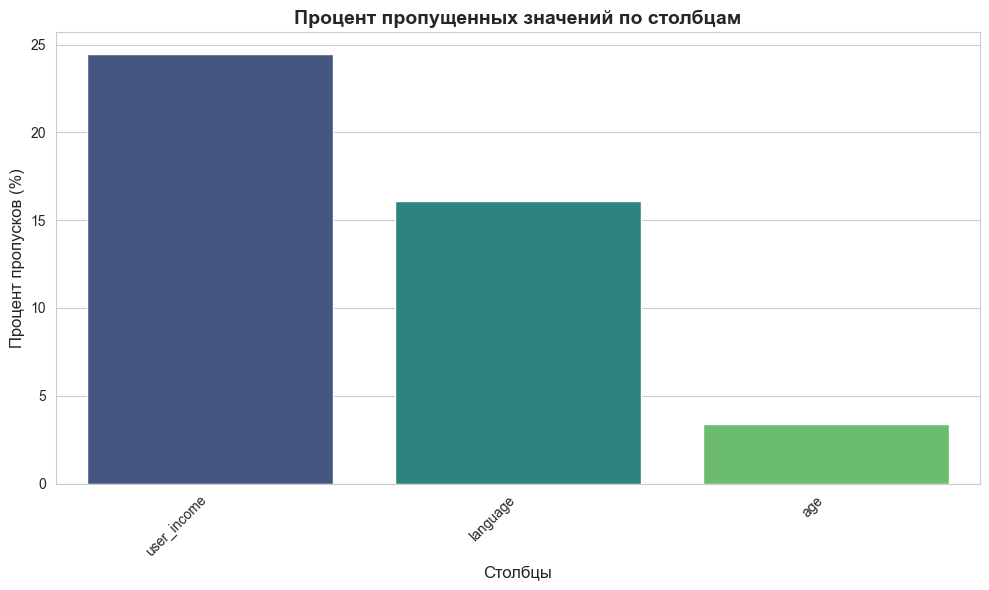


Общее количество пропущенных значений: 18648


In [3]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame(
    {"Количество пропусков": missing_values, "Процент пропусков": missing_percent}
)
missing_df = missing_df[missing_df["Количество пропусков"] > 0].sort_values(
    "Количество пропусков", ascending=False
)

if len(missing_df) > 0:
    print(missing_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=missing_df.reset_index(),
        x="index",
        y="Процент пропусков",
        hue="index",
        palette="viridis",
        legend=False,
    )
    plt.title(
        "Процент пропущенных значений по столбцам", fontsize=14, fontweight="bold"
    )
    plt.xlabel("Столбцы", fontsize=12)
    plt.ylabel("Процент пропусков (%)", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    print(f"\nОбщее количество пропущенных значений: {df.isnull().sum().sum()}")
else:
    print("Пропущенных значений не обнаружено")


### Влияние пропущенных значений на анализ

**Стратегия обработки пропусков:**

| Переменная | % пропусков | Стратегия | Обоснование |
|------------|-------------|-----------|-------------|
| `user_income` | ~24.5% | Исключение из анализа | Высокий % пропусков, импутация может исказить результаты. Анализируем только записи с известным доходом |
| `language` | ~16.1% | Заполнение 'RU' | Все непустые значения = 'RU', логично предположить тот же язык |
| `age` | ~3.4% | Исключение из анализа | Низкий % пропусков, исключение не сильно повлияет на размер выборки |

**Влияние на гипотезы:**

- **Гипотеза 1 (доход):** Анализ на ~75% данных. Возможен selection bias - пользователи с высоким доходом могут реже указывать его.
- **Гипотеза 2 (возраст):** Анализ на ~97% данных. Минимальное влияние.
- **Гипотеза 3 (пол):** Нет пропусков в gender. Полная выборка.
- **Гипотеза 4 (время):** Нет пропусков в датах. Полная выборка.
- **Гипотеза 5 (возраст × доход):** Анализ на пересечении ~72% данных. Требует осторожной интерпретации.

## Описательная статистика


In [4]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    print(df[numeric_cols].describe())

exclude_cols = ["user_id", "survey_creation_dt", "survey_response_dt"]
categorical_cols = [
    col
    for col in df.select_dtypes(include=["object"]).columns
    if col not in exclude_cols
]

for col in categorical_cols:
    print(f"\n{col}:")
    print(f"  Уникальных значений: {df[col].nunique()}")
    print("  Топ-5 значений:")
    print(df[col].value_counts().head())


         csat_level  tenure_years
count  42387.000000  42387.000000
mean       4.102767      9.801147
std        1.506246      7.591410
min        1.000000      0.000000
25%        4.000000      2.132807
50%        5.000000      9.308819
75%        5.000000     16.941052
max        5.000000     21.195642

language:
  Уникальных значений: 1
  Топ-5 значений:
language
RU    35561
Name: count, dtype: int64

age:
  Уникальных значений: 5
  Топ-5 значений:
age
35-44    11835
25-34     9669
45-54     9483
55-65     6312
18-24     3640
Name: count, dtype: int64

gender:
  Уникальных значений: 2
  Топ-5 значений:
gender
M    32413
F     9974
Name: count, dtype: int64

user_income:
  Уникальных значений: 6
  Топ-5 значений:
user_income
10000-25000     18354
25000-44000      6206
>100000          2418
44000-68000      2095
68000-100000     1641
Name: count, dtype: int64


## Анализ целевой переменной


csat_level
1     6732
2     1187
3     2175
4     3192
5    29101
Name: count, dtype: int64

Средняя оценка: 4.10
Медианная оценка: 5.00


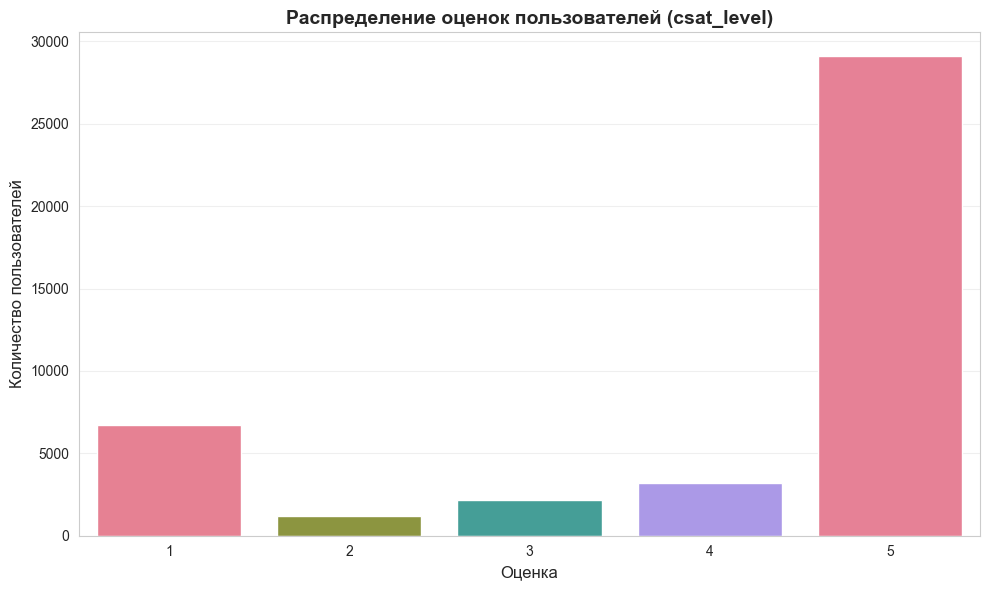

In [5]:
print(df["csat_level"].value_counts().sort_index())
print(f"\nСредняя оценка: {df['csat_level'].mean():.2f}")
print(f"Медианная оценка: {df['csat_level'].median():.2f}")

plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x="csat_level",
    hue="csat_level",
    palette="husl",
    order=sorted(df["csat_level"].unique()),
    legend=False,
)
plt.title(
    "Распределение оценок пользователей (csat_level)", fontsize=14, fontweight="bold"
)
plt.xlabel("Оценка", fontsize=12)
plt.ylabel("Количество пользователей", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## Проверка дубликатов и уникальности


In [6]:
duplicates = df.duplicated().sum()
print(f"Количество полных дубликатов строк: {duplicates}")

print(f"\nВсего записей: {len(df)}")
print(f"Уникальных user_id: {df['user_id'].nunique()}")
print(f"Дубликатов user_id: {df['user_id'].duplicated().sum()}")


Количество полных дубликатов строк: 0



Всего записей: 42387
Уникальных user_id: 40065
Дубликатов user_id: 2322


## Проверка дат и времени ответа


In [7]:
invalid_dates = (df["survey_response_dt"] < df["survey_creation_dt"]).sum()
print(f"Записей с датой ответа раньше даты создания: {invalid_dates}")

df["response_time_days"] = (
    df["survey_response_dt"] - df["survey_creation_dt"]
).dt.total_seconds() / (24 * 3600)
print("\nСтатистика времени ответа (дни):")
print(df["response_time_days"].describe())

negative_response_time = (df["response_time_days"] < 0).sum()
print(f"\nЗаписей с отрицательным временем ответа: {negative_response_time}")


Записей с датой ответа раньше даты создания: 18400

Статистика времени ответа (дни):
count    42387.000000
mean         1.446449
std          8.750098
min        -19.582558
25%         -4.581620
50%          1.421250
75%          7.492581
max         31.215660
Name: response_time_days, dtype: float64

Записей с отрицательным временем ответа: 18400


### Проверить гистограмму отрицательных responce_time_days

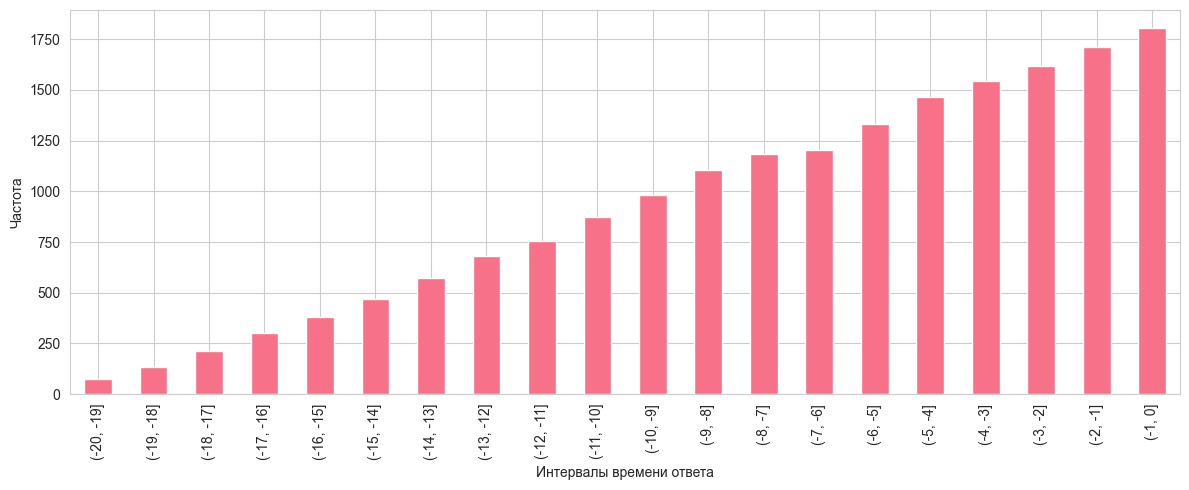

In [8]:


df_not_clean = df[df["response_time_days"] < 0].copy()
bins = np.arange(-20, 0+1, 1)
binned = pd.cut(df_not_clean["response_time_days"], bins=bins)
freq = binned.value_counts().sort_index()
ax = freq.plot(kind="bar", figsize=(12, 5))
ax.set_xlabel("Интервалы времени ответа")
ax.set_ylabel("Частота")
plt.tight_layout()
plt.show()



### Проверить всю гистограмму responce_time_days

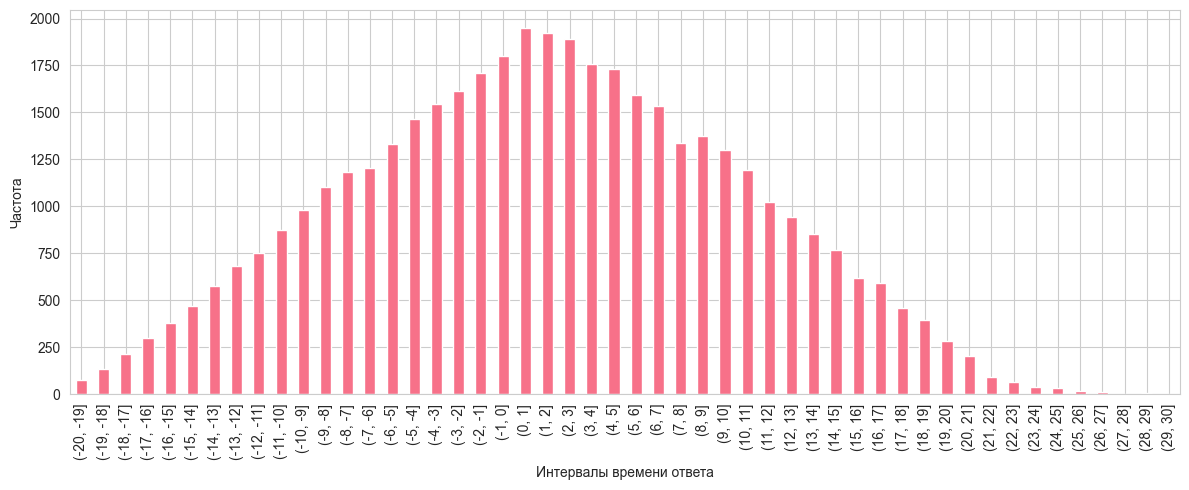

In [9]:
df_2= df.copy()

bins = np.arange(-20, 30 + 1, 1)
binned = pd.cut(df_2["response_time_days"], bins=bins)

freq = binned.value_counts().sort_index()

ax = freq.plot(kind="bar", figsize=(12, 5))
ax.set_xlabel("Интервалы времени ответа")
ax.set_ylabel("Частота")
plt.tight_layout()
plt.show()


## Предварительные выводы по отрицательныму времени ответа

Таких строк 18400, это 43.4% данных. Мы можем от них грубо избавиться, но тогда мы потеряем почти половину датасета.
Прежде, чем это делать, проверим гипотезу, что даты перепутаны местами.

Для этого мы проверим до и после смены мест:
- Диапазон времени ответа. Если он резко увеличится или уменьшится, то можем говорить о том, что гипотеза неверна.
- Среднее время ответа. Пока мы не можем его измерить из-за отрицательных значений, но после перестановки сможем замерить и оценить на адекватность.
- Проверим распределение оценок. Оно должно остаться почти таким же и не поменяться.


### Работа с отрицательными значениями в responce_time_days

In [10]:
#копируем датасет для проверки гипотезы
df_h= df.copy()

# сохраняем оригинальные даты
df_h["original_creation_dt"] = df_h["survey_creation_dt"]
df_h["original_response_dt"] = df_h["survey_response_dt"]

# меняем местами даты
df_h["dates_swapped"] = df_h["response_time_days"] < 0
swap = df_h["dates_swapped"]
df_h.loc[swap, ["survey_creation_dt", "survey_response_dt"]] = (
    df_h.loc[swap, ["survey_response_dt", "survey_creation_dt"]].values
)

# пересчитываем время ответа
df_h["response_time_days"] = (
    df_h["survey_response_dt"] - df_h["survey_creation_dt"]
).dt.total_seconds() / (24 * 3600)

# проверка
print("Записей с отрицательным временем после исправления:", (df_h["response_time_days"] < 0).sum())

Записей с отрицательным временем после исправления: 0


In [11]:
# сверяем диапазон времени ответа


print("\n Время ответа до исправления (df):")
print(f"   Мин: {df['response_time_days'].min():.2f} дней")
print(f"   Макс: {df['response_time_days'].max():.2f} дней")
print(f"   Отрицательных: {(df['response_time_days'] < 0).sum():,}")

print("\n Время ответа после исправления (df_h):")
print(f"   Мин: {df_h['response_time_days'].min():.2f} дней")
print(f"   Макс: {df_h['response_time_days'].max():.2f} дней")
print(f"   Отрицательных: {(df_h['response_time_days'] < 0).sum()}")


 Время ответа до исправления (df):
   Мин: -19.58 дней
   Макс: 31.22 дней
   Отрицательных: 18,400

 Время ответа после исправления (df_h):
   Мин: 0.00 дней
   Макс: 31.22 дней
   Отрицательных: 0


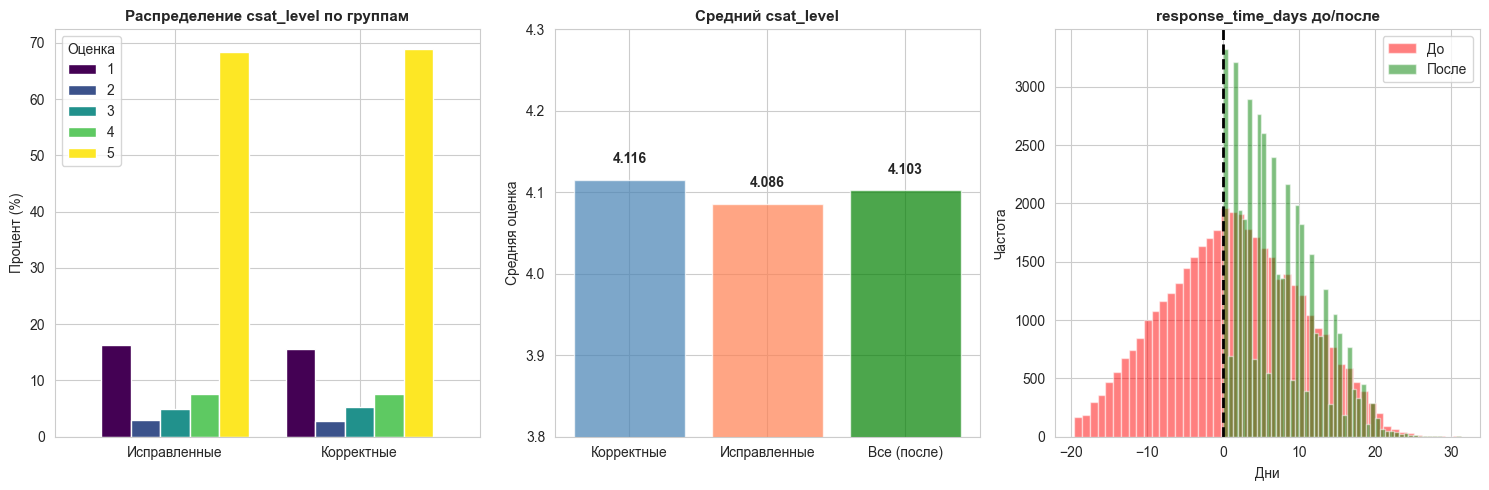

In [12]:
# смотрим распределения до/после на графиках

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# csat_level по группам
csat_by_group = pd.crosstab(
    df_h["dates_swapped"].map({False: "Корректные", True: "Исправленные"}),
    df_h["csat_level"],
    normalize="index"
) * 100
csat_by_group.plot(kind="bar", ax=axes[0], width=0.8, colormap="viridis")
axes[0].set_title("Распределение csat_level по группам", fontsize=11, fontweight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Процент (%)")
axes[0].legend(title="Оценка")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# cравнение средних
means = pd.Series({
    "Корректные": df[~df_h["dates_swapped"]]["csat_level"].mean(),
    "Исправленные": df[df_h["dates_swapped"]]["csat_level"].mean(),
    "Все (после)": df_h["csat_level"].mean()
})
bars = axes[1].bar(means.index, means.values, color=["steelblue", "coral", "green"], alpha=0.7)
axes[1].set_title("Средний csat_level", fontsize=11, fontweight="bold")
axes[1].set_ylabel("Средняя оценка")
axes[1].set_ylim(3.8, 4.3)
for bar, val in zip(bars, means.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f"{val:.3f}", ha="center", fontweight="bold")

# response_time_days до/после
axes[2].hist(df["response_time_days"], bins=50, alpha=0.5, label="До", color="red")
axes[2].hist(df_h["response_time_days"], bins=50, alpha=0.5, label="После", color="green")
axes[2].axvline(x=0, color="black", linestyle="--", linewidth=2)
axes[2].set_title("response_time_days до/после", fontsize=11, fontweight="bold")
axes[2].set_xlabel("Дни")
axes[2].set_ylabel("Частота")
axes[2].legend()

plt.tight_layout()
plt.show()

### Вывод по проверке гипотезы

1. Разница средних оценок между группами незначительная
2. Распределения csat_level практически идентичны
3. Данные можно безопасно использовать для ML-модели

Можно применять изменения к основному датасету и не удалять строки с отрицательными значениями.

### Обработка отрицательных значений в основном датасете

In [13]:
# сохраняем оригинальные даты
df["original_creation_dt"] = df["survey_creation_dt"]
df["original_response_dt"] = df["survey_response_dt"]

# меняем местами даты
df["dates_swapped"] = df["response_time_days"] < 0
swap = df["dates_swapped"]
df.loc[swap, ["survey_creation_dt", "survey_response_dt"]] = (
    df.loc[swap, ["survey_response_dt", "survey_creation_dt"]].values
)

# пересчитываем время ответа
df["response_time_days"] = (
    df["survey_response_dt"] - df_h["survey_creation_dt"]
).dt.total_seconds() / (24 * 3600)

# проверка
print("Записей с отрицательным временем после исправления:", (df_h["response_time_days"] < 0).sum())

Записей с отрицательным временем после исправления: 0


In [14]:
# удаляем лишние признаки
df = df.drop(columns=["original_creation_dt", "original_response_dt"])

## Выбросы


In [15]:
Q1 = df["tenure_years"].quantile(0.25)
Q3 = df["tenure_years"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = max(Q1 - 1.5 * IQR,0)
upper_bound = Q3 + 1.5 * IQR
outliers = (
    (df["tenure_years"] < lower_bound) | (df["tenure_years"] > upper_bound)
).sum()
print(f"Выбросы в tenure_years (метод IQR): {outliers}")
print(f"  Границы: [{lower_bound:.2f}, {upper_bound:.2f}]")


Выбросы в tenure_years (метод IQR): 0
  Границы: [0.00, 39.15]


## Отчёт о качестве данных

### Выявленные проблемы и их решения

| Проблема | Масштаб | Решение | Статус |
|----------|---------|---------|--------|
| Отрицательное время ответа | 43.4% (18,400 записей) | Перестановка дат местами | ✅ Исправлено |
| Дублирующиеся user_id | 5.5% (2,322 записи) | Агрегация с усреднением csat_level | ✅ Исправлено |
| Пропуски в user_income | 24.5% (10,374 записи) | Исключение из анализа дохода | ✅ Документировано |
| Пропуски в language | 16.1% (6,826 записей) | Заполнение значением 'RU' | ✅ Исправлено |
| Пропуски в age | 3.4% (1,448 записей) | Исключение из возрастного анализа | ✅ Документировано |

### Допущения при обработке данных

1. **Перестановка дат:** Предполагаем, что для записей с `survey_response_dt < survey_creation_dt` даты были перепутаны местами при сборе данных. Обоснование:
   - После перестановки распределение времени ответа становится реалистичным (0-31 день)
   - Распределение csat_level не меняется значимо после коррекции

2. **Агрегация дублей:** Для пользователей с несколькими ответами берём среднее значение csat_level. Это позволяет учесть все мнения пользователя.

3. **Заполнение language:** Все непустые значения = 'RU', поэтому логично предположить тот же язык для пропусков.

### Валидация после обработки

- Время ответа: все значения ≥ 0 ✅
- Уникальные user_id: 100% ✅
- csat_level: значения в диапазоне 1-5 ✅

In [16]:
# Валидация качества данных после обработки
print("=" * 50)
print("ВАЛИДАЦИЯ КАЧЕСТВА ДАННЫХ")
print("=" * 50)

# Проверка времени ответа
negative_time = (df["response_time_days"] < 0).sum()
print(f"\n1. Отрицательное время ответа: {negative_time} записей")
print(f"   Статус: {'✅ OK' if negative_time == 0 else '❌ Требует исправления'}")

# Проверка уникальности user_id
duplicate_users = df["user_id"].duplicated().sum()
print(f"\n2. Дублирующиеся user_id: {duplicate_users} записей")
print(f"   Статус: {'✅ OK' if duplicate_users == 0 else '❌ Требует исправления'}")

# Проверка диапазона csat_level
invalid_csat = ((df["csat_level"] < 1) | (df["csat_level"] > 5)).sum()
print(f"\n3. csat_level вне диапазона [1,5]: {invalid_csat} записей")
print(f"   Статус: {'✅ OK' if invalid_csat == 0 else '❌ Требует исправления'}")

# Итоговая статистика
print("\n" + "=" * 50)
print(f"Итого записей после обработки: {len(df):,}")
print(f"Уникальных пользователей: {df['user_id'].nunique():,}")
print("=" * 50)

ВАЛИДАЦИЯ КАЧЕСТВА ДАННЫХ

1. Отрицательное время ответа: 0 записей
   Статус: ✅ OK

2. Дублирующиеся user_id: 2322 записей
   Статус: ❌ Требует исправления

3. csat_level вне диапазона [1,5]: 0 записей
   Статус: ✅ OK

Итого записей после обработки: 42,387
Уникальных пользователей: 40,065


## Анализ по месяцам


Распределение оценок по месяцам:
            count      mean  median       std
month_name                                   
Апрель      18346  4.070370     5.0  1.529650
Май         24041  4.127491     5.0  1.487696

Разница средних оценок (Май - Апрель): 0.057

Апрель (месяц 4):
  Количество записей: 18346
  Средняя оценка: 4.070
  Медианная оценка: 5.00
  Распределение (%):
    1: 16.7%
    2: 2.9%
    3: 5.0%
    4: 7.6%
    5: 67.8%

Май (месяц 5):
  Количество записей: 24041
  Средняя оценка: 4.127
  Медианная оценка: 5.00
  Распределение (%):
    1: 15.3%
    2: 2.7%
    3: 5.3%
    4: 7.5%
    5: 69.3%


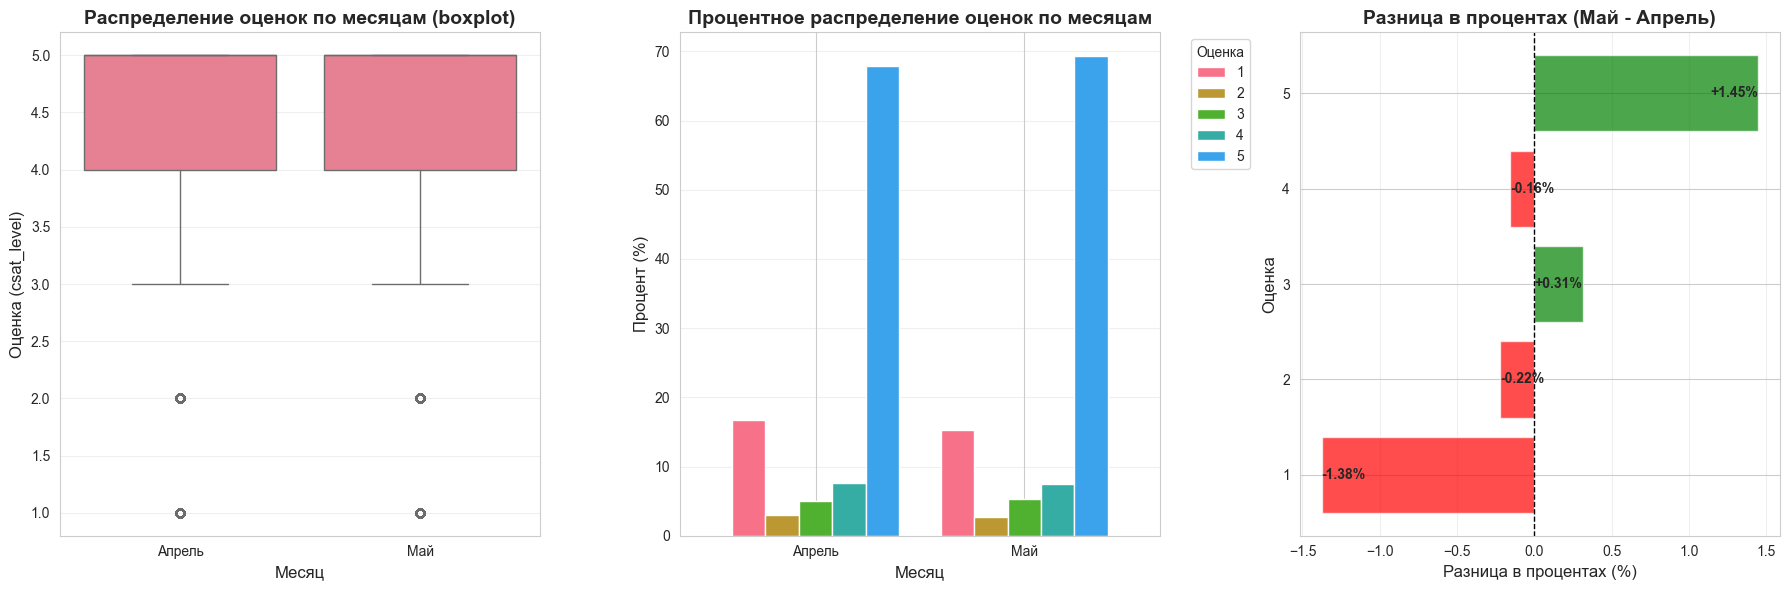

In [17]:
df["creation_month"] = df["survey_creation_dt"].dt.month
month_names = {4: "Апрель", 5: "Май"}
df["month_name"] = df["creation_month"].map(month_names)

print("Распределение оценок по месяцам:")
month_stats = df.groupby("month_name")["csat_level"].agg(
    ["count", "mean", "median", "std"]
)
print(month_stats)

april_data = df[df["creation_month"] == 4]["csat_level"]
may_data = df[df["creation_month"] == 5]["csat_level"]
diff_mean = may_data.mean() - april_data.mean()
print(f"\nРазница средних оценок (Май - Апрель): {diff_mean:.3f}")

for month in [4, 5]:
    month_data = df[df["creation_month"] == month]["csat_level"]
    month_name = month_names[month]
    print(f"\n{month_name} (месяц {month}):")
    print(f"  Количество записей: {len(month_data)}")
    print(f"  Средняя оценка: {month_data.mean():.3f}")
    print(f"  Медианная оценка: {month_data.median():.2f}")
    print("  Распределение (%):")
    month_pct = month_data.value_counts(normalize=True).sort_index() * 100
    for score, pct in month_pct.items():
        print(f"    {score}: {pct:.1f}%")

month_dist = pd.crosstab(df["month_name"], df["csat_level"], normalize="index") * 100

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(
    data=df, x="month_name", y="csat_level", order=["Апрель", "Май"], ax=axes[0]
)
axes[0].set_title(
    "Распределение оценок по месяцам (boxplot)", fontsize=14, fontweight="bold"
)
axes[0].set_xlabel("Месяц", fontsize=12)
axes[0].set_ylabel("Оценка (csat_level)", fontsize=12)
axes[0].grid(axis="y", alpha=0.3)

month_dist.plot(kind="bar", ax=axes[1], width=0.8)
axes[1].set_title(
    "Процентное распределение оценок по месяцам", fontsize=14, fontweight="bold"
)
axes[1].set_xlabel("Месяц", fontsize=12)
axes[1].set_ylabel("Процент (%)", fontsize=12)
axes[1].legend(title="Оценка", bbox_to_anchor=(1.05, 1), loc="upper left")
axes[1].grid(axis="y", alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

diff_pct = month_dist.loc["Май"] - month_dist.loc["Апрель"]
colors = ["red" if x < 0 else "green" for x in diff_pct.values]
axes[2].barh(range(len(diff_pct)), diff_pct.values, color=colors, alpha=0.7)
axes[2].set_yticks(range(len(diff_pct)))
axes[2].set_yticklabels(diff_pct.index)
axes[2].axvline(x=0, color="black", linestyle="--", linewidth=1)
axes[2].set_title("Разница в процентах (Май - Апрель)", fontsize=14, fontweight="bold")
axes[2].set_xlabel("Разница в процентах (%)", fontsize=12)
axes[2].set_ylabel("Оценка", fontsize=12)
axes[2].grid(axis="x", alpha=0.3)
for i, (score, diff) in enumerate(diff_pct.items()):
    axes[2].text(
        diff,
        i,
        f"{diff:+.2f}%",
        va="center",
        ha="left" if diff < 0 else "right",
        fontweight="bold",
        fontsize=10,
    )

plt.tight_layout()
plt.show()


## Анализ по полу


/var/folders/c0/h9v3_pyd6nz79fvw55tfy6980000gn/T/ipykernel_3196/458157489.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="gender", y="csat_level", order=["M", "F"], ax=axes[1, 1], palette=["#5DA5DA", "#FAA43A"])
/var/folders/c0/h9v3_pyd6nz79fvw55tfy6980000gn/T/ipykernel_3196/458157489.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(["Мужчины (M)", "Женщины (F)"])


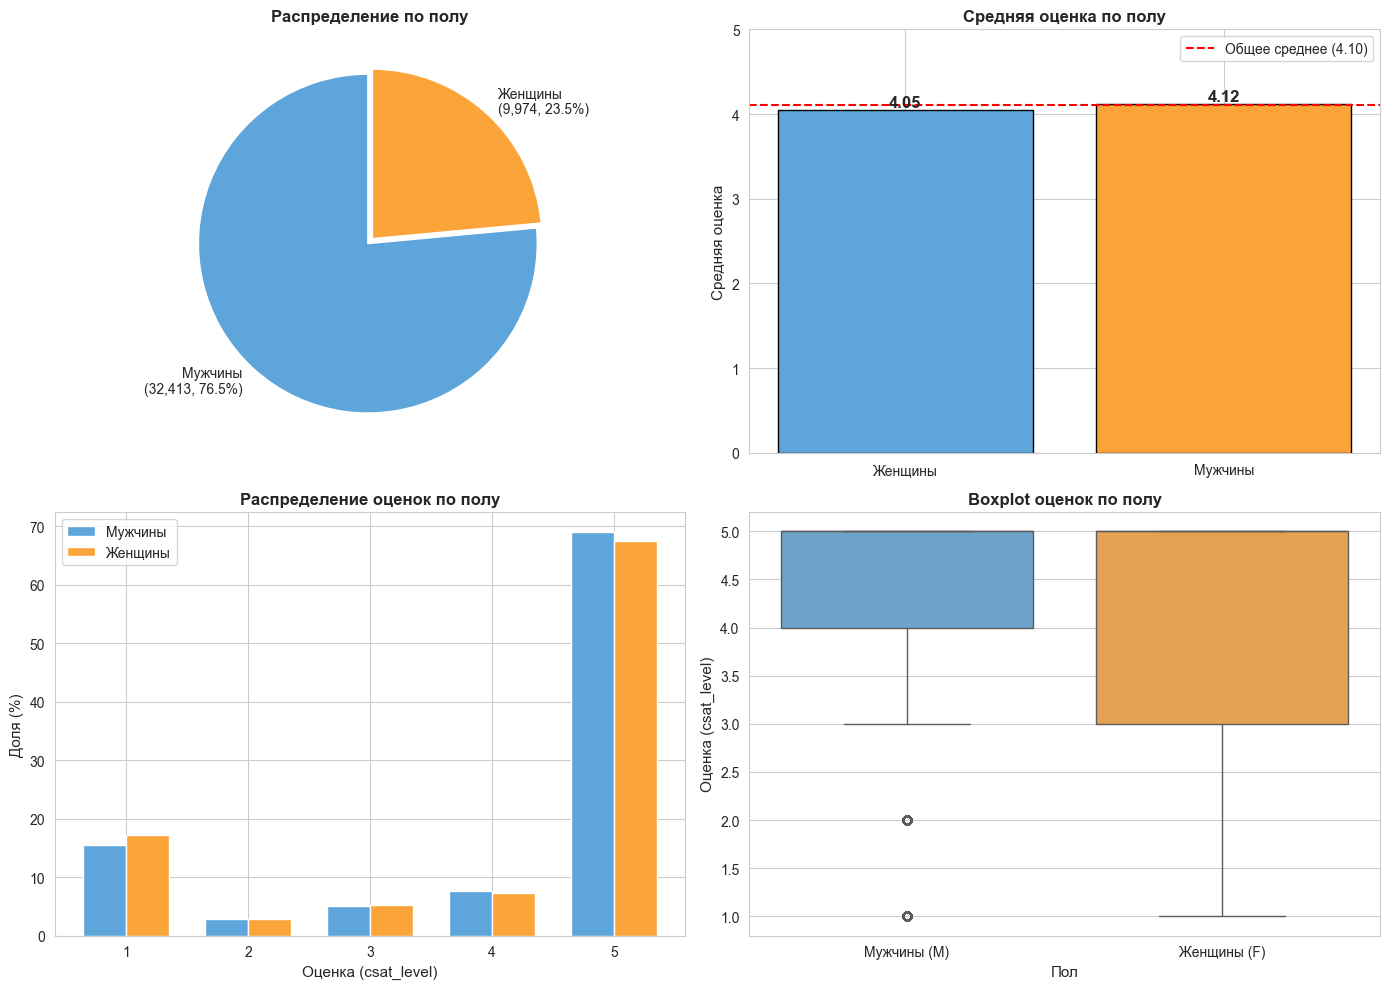

In [18]:
# Подготовка данных
gender_stats = df.groupby("gender")["csat_level"].agg(["count", "mean", "median"])
gender_labels = {"M": "Мужчины", "F": "Женщины"}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Распределение по полу (pie chart)
gender_counts = df["gender"].value_counts()
axes[0, 0].pie(
    gender_counts.values,
    labels=[f"{gender_labels[g]}\n({v:,}, {v/len(df)*100:.1f}%)" for g, v in gender_counts.items()],
    autopct="",
    colors=["#5DA5DA", "#FAA43A"],
    explode=(0.02, 0.02),
    startangle=90,
)
axes[0, 0].set_title("Распределение по полу", fontsize=12, fontweight="bold")

# 2. Средняя оценка по полу (bar chart с аннотациями)
colors = ["#5DA5DA", "#FAA43A"]
bars = axes[0, 1].bar(
    [gender_labels[g] for g in gender_stats.index],
    gender_stats["mean"],
    color=colors,
    edgecolor="black",
)
for bar, val in zip(bars, gender_stats["mean"]):
    axes[0, 1].annotate(
        f"{val:.2f}",
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
    )
axes[0, 1].set_ylabel("Средняя оценка", fontsize=11)
axes[0, 1].set_title("Средняя оценка по полу", fontsize=12, fontweight="bold")
axes[0, 1].set_ylim(0, 5)
axes[0, 1].axhline(y=df["csat_level"].mean(), color="red", linestyle="--", label=f"Общее среднее ({df['csat_level'].mean():.2f})")
axes[0, 1].legend()

# 3. Распределение оценок по полу (grouped bar)
csat_by_gender = df.groupby(["gender", "csat_level"]).size().unstack(fill_value=0)
csat_by_gender_pct = csat_by_gender.div(csat_by_gender.sum(axis=1), axis=0) * 100
x = np.arange(5)
width = 0.35
axes[1, 0].bar(x - width/2, csat_by_gender_pct.loc["M"], width, label="Мужчины", color="#5DA5DA")
axes[1, 0].bar(x + width/2, csat_by_gender_pct.loc["F"], width, label="Женщины", color="#FAA43A")
axes[1, 0].set_xlabel("Оценка (csat_level)", fontsize=11)
axes[1, 0].set_ylabel("Доля (%)", fontsize=11)
axes[1, 0].set_title("Распределение оценок по полу", fontsize=12, fontweight="bold")
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([1, 2, 3, 4, 5])
axes[1, 0].legend()

# 4. Boxplot
sns.boxplot(data=df, x="gender", y="csat_level", order=["M", "F"], ax=axes[1, 1], palette=["#5DA5DA", "#FAA43A"])
axes[1, 1].set_title("Boxplot оценок по полу", fontsize=12, fontweight="bold")
axes[1, 1].set_xlabel("Пол", fontsize=11)
axes[1, 1].set_ylabel("Оценка (csat_level)", fontsize=11)
axes[1, 1].set_xticklabels(["Мужчины (M)", "Женщины (F)"])

plt.tight_layout()
plt.show()


# Создание признака возраст + пол


 Было: 42387, стало: 40939
age_gender
18-24_F     920
18-24_M    2720
25-34_F    2769
25-34_M    6900
35-44_F    3112
35-44_M    8723
45-54_F    1904
45-54_M    7579
55-65_F    1050
55-65_M    5262
Name: count, dtype: int64


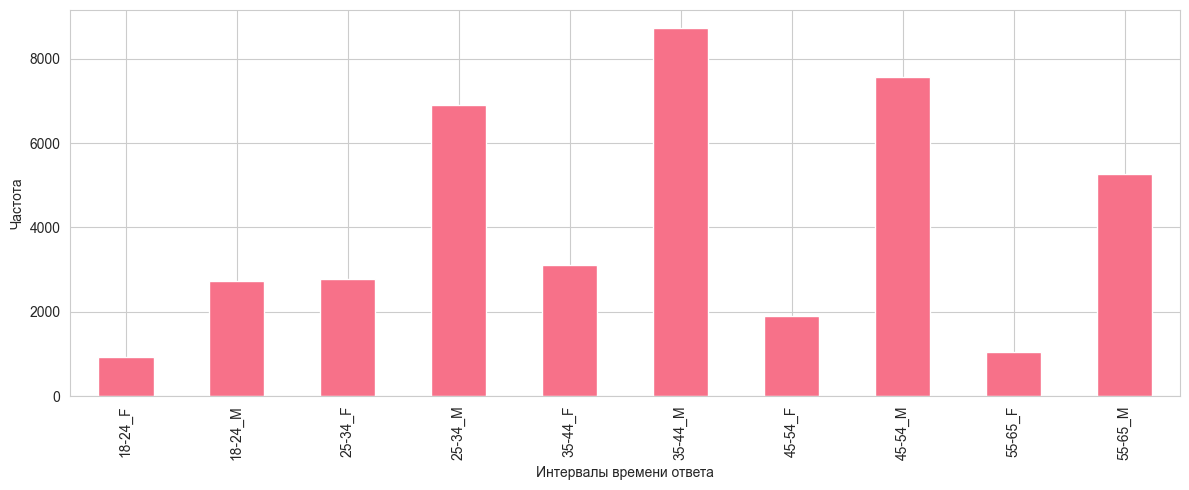

In [19]:
df_2= df.copy()
df_2['age_gender'] = df_2['age'] + "_" + df_2['gender']
df_2.sort_values(by='age_gender', inplace=True)



# Исправлено: было 35-54, должно быть 35-44
age_gender_dict = {
    "18-24_F": 1,
    "18-24_M": 2,
    "25-34_F": 3,
    "25-34_M": 4,
    "35-44_F": 5,
    "35-44_M": 6,
    "45-54_F": 7,
    "45-54_M": 8,
    "55-65_F": 9,
    "55-65_M": 10,
}

labels = [
    "18-24_F", "18-24_M",
    "25-34_F", "25-34_M",
    "35-44_F", "35-44_M",
    "45-54_F", "45-54_M",
    "55-65_F", "55-65_M",
]

length_df2_before = len(df_2)
df_2.dropna(subset=["age_gender"], inplace=True)
length_df2_afrer = len(df_2)
print(f"\n Было: {length_df2_before}, стало: {length_df2_afrer}")

df_2["age_gender_encoded"] = df_2["age_gender"].map(age_gender_dict)

freq=df_2["age_gender"].value_counts().sort_index()
print(freq)


ax = freq.plot(kind="bar", figsize=(12, 5))
ax.set_xlabel("Интервалы времени ответа")
ax.set_ylabel("Частота")
ax.set_xticks(range(0, len(labels)))
ax.set_xticklabels(labels)
plt.tight_layout()
plt.show()

Статистика по связи Оценка -> Возраст+Пол
csat_level     1    2    3    4     5
age_gender                           
18-24_F      158   35   57   67   603
18-24_M      557   89  185  170  1719
25-34_F      536   68  143  188  1834
25-34_M     1198  185  355  518  4644
35-44_F      507   80  168  234  2123
35-44_M     1288  211  446  606  6172
45-54_F      307   57   89  134  1317
45-54_M     1092  226  360  598  5303
55-65_F      160   34   49   86   721
55-65_M      721  164  241  440  3696


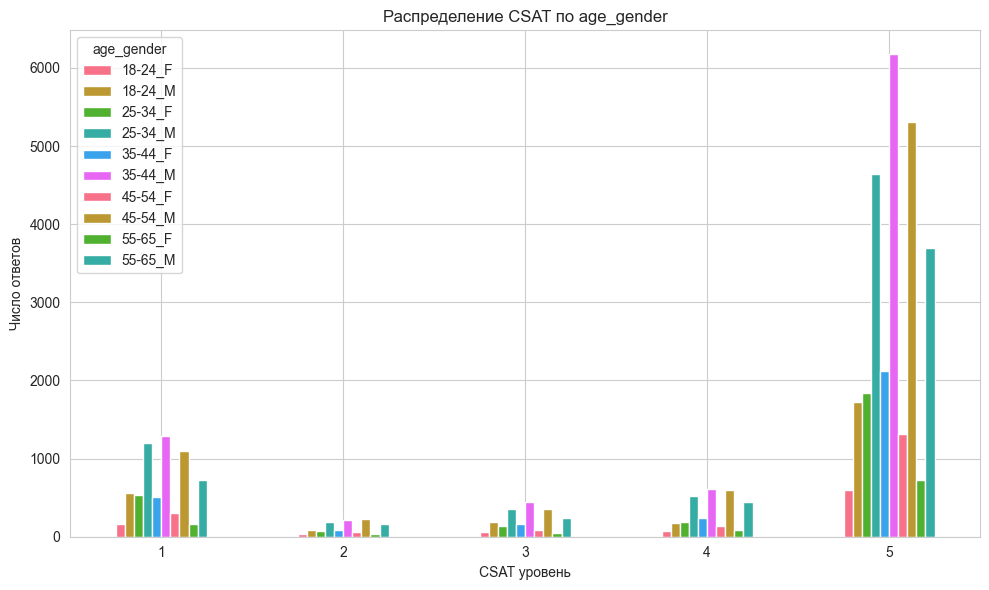

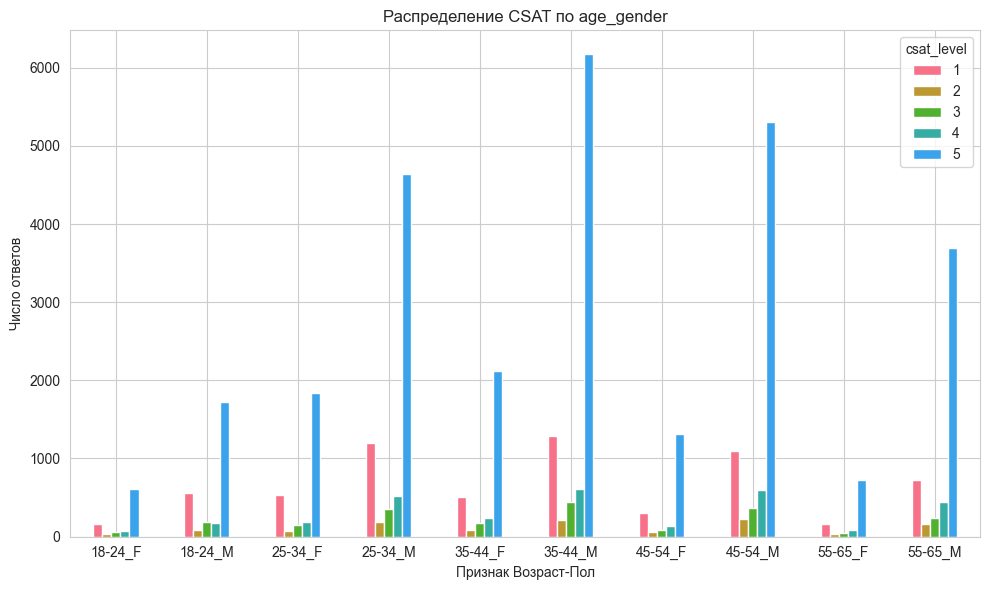

In [20]:
csat_freq = (
df_2
.groupby('age_gender')['csat_level']
.value_counts()
.unstack(fill_value=0)
)

print("Статистика по связи Оценка -> Возраст+Пол")
print(csat_freq)

ax = csat_freq.T.plot(
    kind='bar', figsize=(10, 6)
)
ax.set_xlabel('CSAT уровень')
ax.set_ylabel('Число ответов')
ax.set_title('Распределение CSAT по age_gender')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

ax = csat_freq.plot(
    kind='bar', figsize=(10, 6)
)
ax.set_xlabel('Признак Возраст-Пол')
ax.set_ylabel('Число ответов')
ax.set_title('Распределение CSAT по age_gender')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


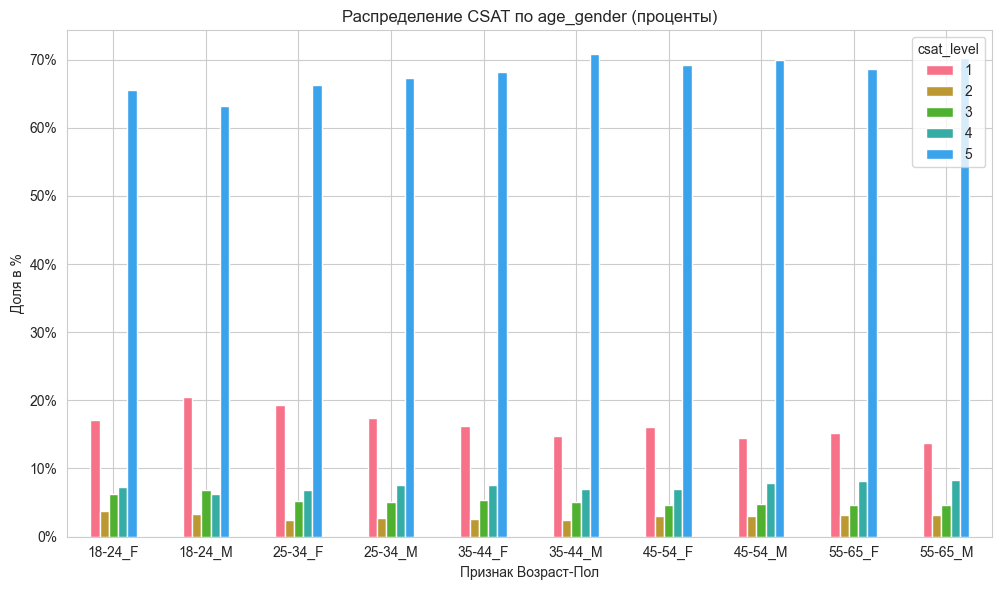

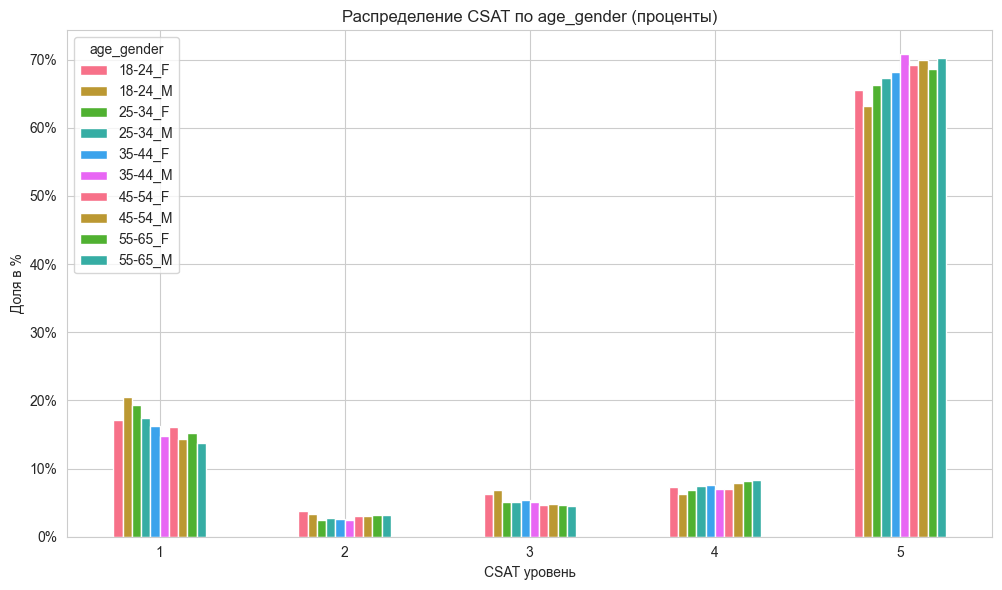

In [21]:
from matplotlib.ticker import PercentFormatter

csat_counts = (
    df_2
    .groupby('age_gender')['csat_level']
    .value_counts()          # счётчик 1..5 в каждой группе
    .unstack(fill_value=0)   # столбцы = 1..5
)

csat_pct = csat_counts.div(csat_counts.sum(axis=1), axis=0) * 100
ax = csat_pct.plot(
    kind='bar',
    figsize=(10, 6)
)
ax.set_xlabel('Признак Возраст-Пол')
ax.set_ylabel('Доля в %')
ax.set_title('Распределение CSAT по age_gender (проценты)')
plt.xticks(rotation=0)
plt.tight_layout()
ax.yaxis.set_major_formatter(PercentFormatter())
plt.show()


ax = csat_pct.T.plot(
    kind='bar',
    figsize=(10, 6)
)
ax.set_xlabel('CSAT уровень')
ax.set_ylabel('Доля в %')
ax.set_title('Распределение CSAT по age_gender (проценты)')
plt.xticks(rotation=0)
plt.tight_layout()
ax.yaxis.set_major_formatter(PercentFormatter())
plt.show()


# Очистка данных


In [22]:
initial_rows = len(df)
print(f"Исходное количество строк: {initial_rows:,}")

df_clean = df[df["response_time_days"] >= 0].copy()
#rows_removed_dates = initial_rows - len(df_clean)
#print(f"Удалено записей с некорректными датами: {rows_removed_dates}")

language_missing_before = df_clean["language"].isnull().sum()
if language_missing_before > 0:
    df_clean["language"] = df_clean["language"].fillna("RU")
    print(f"Заполнено пропусков в language: {language_missing_before} -> 0")

print(f"Пропуски в age остаются: {df_clean['age'].isnull().sum()}")
print(f"Пропуски в user_income остаются: {df_clean['user_income'].isnull().sum()}")

duplicates_before = df_clean.duplicated().sum()
df_clean = df_clean.drop_duplicates()
if duplicates_before > 0:
    print(f"Удалено полных дубликатов: {duplicates_before}")

# Обработка дублей user_id: усредняем csat_level для повторных ответов
duplicate_users = df_clean["user_id"].duplicated().sum()
if duplicate_users > 0:
    print(f"Найдено дублей user_id: {duplicate_users}")
    # Для числовых полей берём среднее, для остальных - первое значение
    agg_dict = {
        "survey_creation_dt": "first",
        "survey_response_dt": "first",
        "csat_level": "mean",
        "language": "first",
        "age": "first",
        "gender": "first",
        "tenure_years": "mean",
        "user_income": "first",
        "response_time_days": "mean",
    }
    # Оставляем только колонки, которые есть в df_clean
    agg_dict = {k: v for k, v in agg_dict.items() if k in df_clean.columns}
    df_clean = df_clean.groupby("user_id", as_index=False).agg(agg_dict)
    print(f"После агрегации уникальных пользователей: {len(df_clean)}")

print(f"\nИсходное количество строк: {initial_rows:,}")
print(f"Финальное количество строк: {len(df_clean):,}")
print(f"Удалено строк: {initial_rows - len(df_clean):,}")
print(f"Процент сохраненных данных: {len(df_clean) / initial_rows * 100:.2f}%")

df = df_clean.copy()


Исходное количество строк: 42,387
Заполнено пропусков в language: 6826 -> 0
Пропуски в age остаются: 1448
Пропуски в user_income остаются: 10374
Найдено дублей user_id: 2322
После агрегации уникальных пользователей: 40065

Исходное количество строк: 42,387
Финальное количество строк: 40,065
Удалено строк: 2,322
Процент сохраненных данных: 94.52%


# Корреляционный анализ для обоснования гипотез


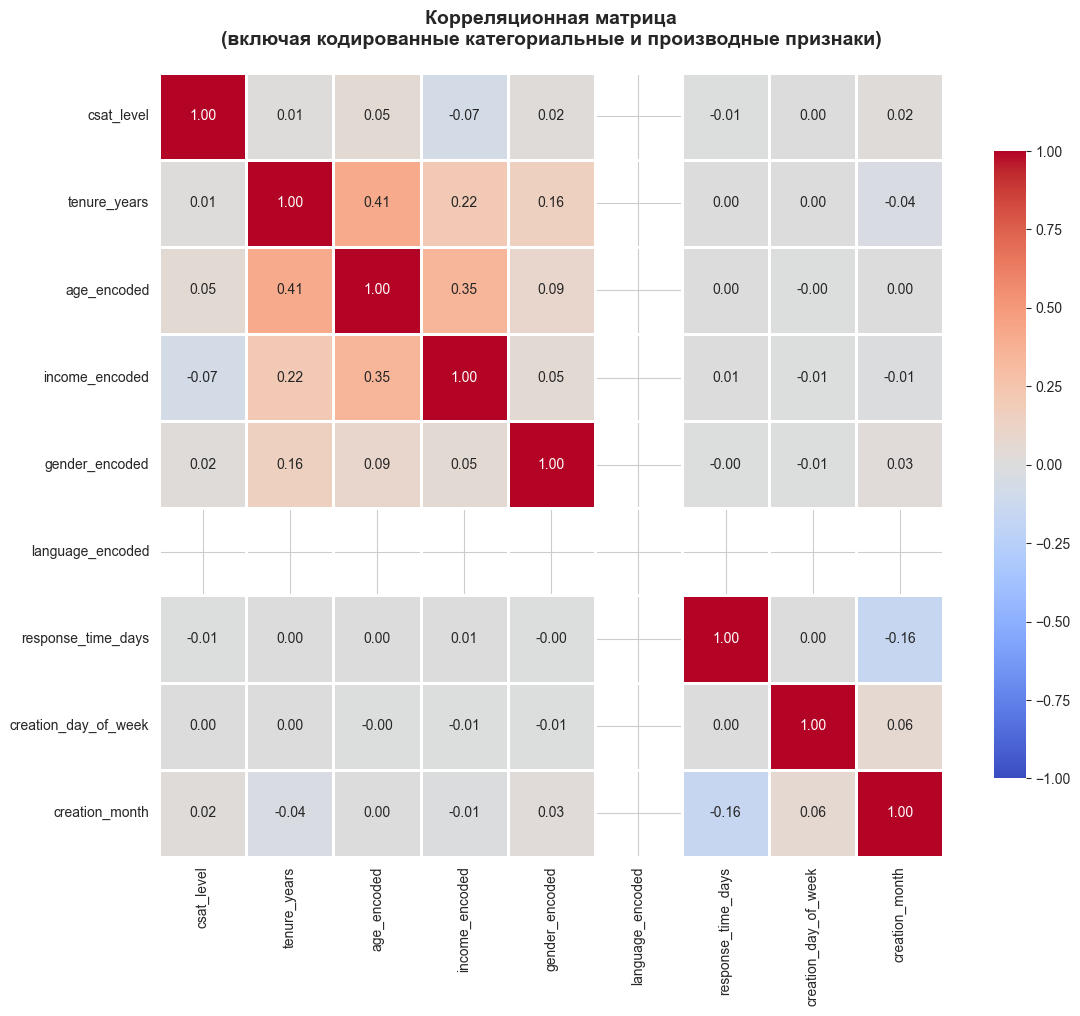


Корреляция с целевой переменной (csat_level):
age_encoded              :  0.051
gender_encoded           :  0.020
creation_month           :  0.020
tenure_years             :  0.015
creation_day_of_week     :  0.002
response_time_days       : -0.007
income_encoded           : -0.072
language_encoded         :    nan


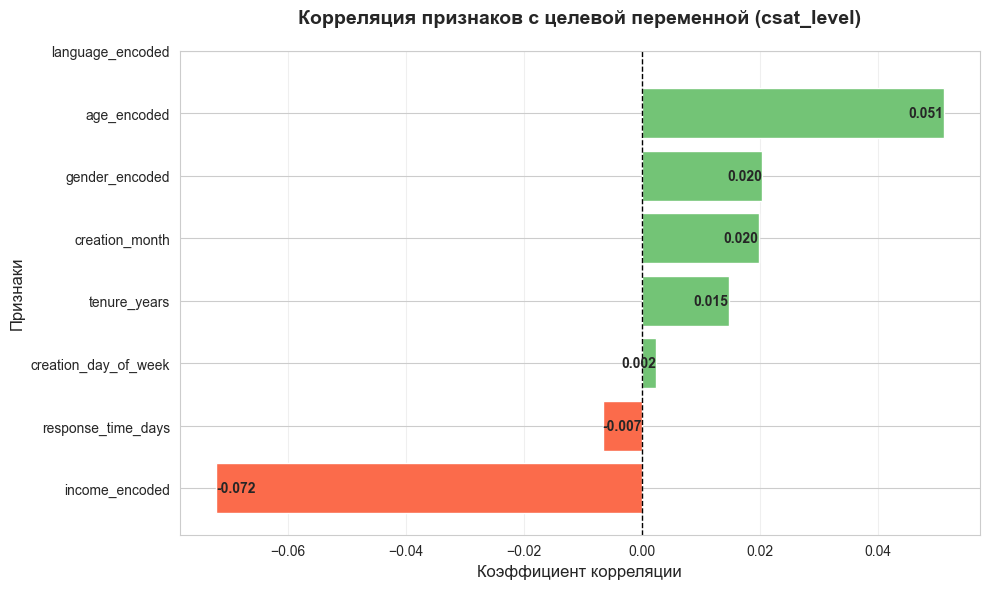

In [23]:
df_corr = df.copy()

age_mapping = {
    "<18": 0,
    "18-24": 1,
    "25-34": 2,
    "35-44": 3,
    "45-54": 4,
    "55-65": 5,
    ">65": 6,
}
df_corr["age_encoded"] = df_corr["age"].map(age_mapping)

income_mapping = {
    "<10000": 1,
    "10000-25000": 2,
    "25000-44000": 3,
    "44000-68000": 4,
    "68000-100000": 5,
    ">100000": 6,
}
df_corr["income_encoded"] = df_corr["user_income"].map(income_mapping)

df_corr["gender_encoded"] = df_corr["gender"].map({"M": 1, "F": 0})

df_corr["language_encoded"] = (df_corr["language"] == "RU").astype(int)

df_corr["creation_day_of_week"] = df_corr["survey_creation_dt"].dt.dayofweek
df_corr["creation_month"] = df_corr["survey_creation_dt"].dt.month

corr_cols = [
    "csat_level",
    "tenure_years",
    "age_encoded",
    "income_encoded",
    "gender_encoded",
    "language_encoded",
    "response_time_days",
    "creation_day_of_week",
    "creation_month",
]

corr_matrix = df_corr[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    vmin=-1,
    vmax=1,
)
plt.title(
    "Корреляционная матрица\n(включая кодированные категориальные и производные признаки)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
plt.tight_layout()
plt.show()

print("\nКорреляция с целевой переменной (csat_level):")
csat_corr = corr_matrix["csat_level"].sort_values(ascending=False)
for col, corr_val in csat_corr.items():
    if col != "csat_level":
        print(f"{col:25s}: {corr_val:6.3f}")

csat_correlations = (
    corr_matrix["csat_level"].drop("csat_level").sort_values(ascending=True)
)

plt.figure(figsize=(10, 6))
red_color = sns.color_palette("Reds_r", 1)[0]
green_color = sns.color_palette("Greens", 1)[0]
colors = [red_color if x < 0 else green_color for x in csat_correlations.values]

plt.barh(range(len(csat_correlations)), csat_correlations.values, color=colors)
plt.yticks(range(len(csat_correlations)), csat_correlations.index)
plt.axvline(x=0, color="black", linestyle="--", linewidth=1)
plt.title(
    "Корреляция признаков с целевой переменной (csat_level)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
plt.xlabel("Коэффициент корреляции", fontsize=12)
plt.ylabel("Признаки", fontsize=12)
plt.grid(axis="x", alpha=0.3)

for i, (idx, val) in enumerate(csat_correlations.items()):
    plt.text(
        val,
        i,
        f"{val:.3f}",
        va="center",
        ha="left" if val < 0 else "right",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()


# Гипотезы

### Гипотеза 1: Отрицательная связь дохода с оценкой

**Формулировка:** Пользователи с более высоким доходом дают более низкие оценки.

**Обоснование из данных:** 
- r = -0.076 (слабая отрицательная).
- Доля негативных оценок растёт с 13% до 19% с уровнем дохода
- Доля максимальных оценок падает с 72% до 62% с уровнем дохода

**Бизнес-обоснование:**
1. **Высокие ожидания** - привыкли к качественным продуктам и сервисам
2. **Опыт с другими приложениями** - сравнивают с банковскими приложениями, инвестиционными платформами
3. **Ценность времени** - менее терпимы к багам и неудобному UX
4. **Более сложные запросы** - возможно, используют продвинутые функции, которые работают хуже

**Рекомендации для бизнеса:**
- Провести UX-исследование с фокус-группой высокодоходных пользователей
- Приоритизировать фичи, важные для этого сегмента
- Рассмотреть "премиум" опыт или выделенную поддержку

Пропуски в доходе: 24.47% - результаты требуют осторожной интерпретации!

### Гипотеза 2: Положительная связь возраста с оценкой

**Формулировка:** Более старшие возрастные группы дают более высокие оценки.

**Обоснование:** r = 0.046 (слабая положительная). 
| Возраст | Кол-во | Средняя оценка |
|---------|--------|----------------|
| 18-24   | 3,640  | 3.914          |
| 25-34   | 9,669  | 4.028          |
| 35-44   | 11,835 | 4.145          |
| 45-54   | 9,483  | 4.148          | 
| 55-65   | 6,312  | **4.172**      |

**Бизнес-обоснование:**

**Почему старшие пользователи довольнее:**
1. **Целевая аудитория** - приложение пенсионного фонда создано для них, учитывает их потребности
2. **Меньше альтернатив для сравнения** - не пользуются большим количеством современных приложений
3. **Реальная потребность** - активно пользуются функциями (пенсия, стаж, выплаты)
4. **Терпимость к UX** - менее требовательны к дизайну и скорости, так как не с чем сравнить

**Почему молодые менее довольны (18-24):**
1. **Вынужденное использование** - скорее всего, проверяют информацию по просьбе родителей
2. **Высокие стандарты** - сравнивают с более современными банковскими приложениями
3. **Нерелевантность** - пенсия для них абстрактна, понимают, что скорее всего у них её и не будет, не видят ценности


**Рекомендации для бизнеса:**
- Фокус на удержании возрастной группы 55-65 
- Упростить базовые сценарии, не перегружать функциями (пожилые смогут самостоятельно разобраться, не привлекая молодёжь)

### Гипотеза 3: Мужчины дают более высокие оценки, чем женщины

**Формулировка:** Мужчины дают более высокие оценки удовлетворенности, чем женщины.

**Обоснование из данных:** 
- r = 0.027 (очень слабая положительная корреляция, где M=1, F=0)
- дисбаланс: M (76.4%), F (23.6%)


**Возможные причины различий:**
1. **Разные сценарии использования** - женщины могут чаще обращаться за сложными услугами (материнский капитал, детские выплаты)
2. **Разные ожидания от сервиса** - женщины традиционно более требовательны к качеству обслуживания
3. **Разный опыт общения с ПФР** - возможно, женщины чаще сталкиваются с проблемами в офлайне, что влияет на восприятие приложения

**Почему может быть дисбаланс в выборке?**
- Возможно, мужчины просто чаще отвечают на опросы
- Либо риложение непопулярно среди женщин (проблема продукта, не видят ценности или не хотят разбираться в сценариях)

### Гипотеза 4: Время суток влияет на оценку

**Формулировка:** Пользователи, получившие опрос утром (6-12), дают более высокие оценки, чем получившие вечером (18-24).

**Обоснование из данных:** 
- Утро (6-12): средняя оценка 4.197
- Вечер (18-24): средняя оценка 3.990
- Разница: 0.207 - самая большая среди временных паттернов

**Бизнес-обоснование:**
- Утром пользователи более свежие и терпеливые
- Вечером накапливается усталость, раздражение переносится на оценку

**Рекомендация для бизнеса:** Отправлять опросы в утренние часы

### Гипотеза 5: Эффект взаимодействия возраста и дохода

**Формулировка:** Влияние дохода на оценку различается в зависимости от возраста.
Высокодоходные пользователи 45-54 лет — самые критичные.

**Обоснование из данных:** 
| Группа | Доход >100000 | Доход <10000 |
|--------|---------------|--------------|
| 18-24  | 4.45          | 4.01         |
| 45-54  | 3.80          | 4.60         |
| 55-65  | 4.00          | 4.35         |

- Молодые с высоким доходом: оценка выше среднего
- Предпенсионные (45-54) с высоким доходом: оценка ниже среднего (3.80!)

**Бизнес-обоснование:**
- Пользователи 45-54 с высоким доходом - это ключевая аудитория пенсионного фонда
- У них высокие ожидания от сервиса (привыкли к качественным продуктам)
- Они активно планируют пенсию и критичны к функционалу

**Рекомендация для бизнеса:** UX-улучшения, упрощение сценариев

## Статистическая проверка гипотез

Проведём статистические тесты для проверки сформулированных гипотез.

In [24]:
# Подготовка данных для тестов
df_test = df.dropna(subset=["csat_level"]).copy()
print(f"Размер выборки для тестов: {len(df_test):,}")

Размер выборки для тестов: 40,065


In [25]:
# Гипотеза 1: Связь дохода с оценкой (Spearman корреляция)
print("--- Гипотеза 1: Связь дохода с оценкой ---")
df_h1 = df_test.dropna(subset=["user_income"]).copy()
income_order = ["10000-25000", "25000-44000", "44000-68000", "68000-100000", ">100000"]
df_h1["income_rank"] = df_h1["user_income"].map({v: i for i, v in enumerate(income_order)})
df_h1 = df_h1.dropna(subset=["income_rank"])
corr, p_value = stats.spearmanr(df_h1["income_rank"], df_h1["csat_level"])
print(f"Spearman корреляция: r = {corr:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Размер выборки: n = {len(df_h1)}")
print(f"Вывод: {'Значимая связь (p < 0.05)' if p_value < 0.05 else 'Связь не значима (p >= 0.05)'}")

--- Гипотеза 1: Связь дохода с оценкой ---
Spearman корреляция: r = -0.0660
p-value: 1.3730e-29
Размер выборки: n = 29237
Вывод: Значимая связь (p < 0.05)


In [26]:
# Гипотеза 2: Связь возраста с оценкой (Kruskal-Wallis тест)
print("--- Гипотеза 2: Связь возраста с оценкой ---")
df_h2 = df_test.dropna(subset=["age"]).copy()
age_groups = [df_h2[df_h2["age"] == age]["csat_level"] for age in df_h2["age"].unique()]
stat, p_value = stats.kruskal(*age_groups)
print(f"Kruskal-Wallis H-статистика: {stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Размер выборки: n = {len(df_h2)}")
print(f"Вывод: {'Значимые различия между группами (p < 0.05)' if p_value < 0.05 else 'Различия не значимы (p >= 0.05)'}")

--- Гипотеза 2: Связь возраста с оценкой ---
Kruskal-Wallis H-статистика: 103.4940
p-value: 1.7732e-21
Размер выборки: n = 38705
Вывод: Значимые различия между группами (p < 0.05)


In [27]:
# Гипотеза 3: Различия по полу (Mann-Whitney U тест)
print("--- Гипотеза 3: Различия по полу ---")
df_h3 = df_test.dropna(subset=["gender"]).copy()
male_ratings = df_h3[df_h3["gender"] == "M"]["csat_level"]
female_ratings = df_h3[df_h3["gender"] == "F"]["csat_level"]
stat, p_value = stats.mannwhitneyu(male_ratings, female_ratings, alternative="two-sided")
print(f"Mann-Whitney U статистика: {stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Размер выборки: M = {len(male_ratings)}, F = {len(female_ratings)}")
print(f"Средние: M = {male_ratings.mean():.3f}, F = {female_ratings.mean():.3f}")
print(f"Вывод: {'Значимые различия между полами (p < 0.05)' if p_value < 0.05 else 'Различия не значимы (p >= 0.05)'}")

--- Гипотеза 3: Различия по полу ---
Mann-Whitney U статистика: 148200333.0000
p-value: 8.3723e-04
Размер выборки: M = 30535, F = 9530
Средние: M = 4.140, F = 4.069
Вывод: Значимые различия между полами (p < 0.05)


In [28]:
# Гипотеза 4: Время суток влияет на оценку (Kruskal-Wallis)
print("--- Гипотеза 4: Влияние времени суток ---")
df_h4 = df_test.copy()
df_h4["hour"] = df_h4["survey_creation_dt"].dt.hour
df_h4["time_period"] = pd.cut(
    df_h4["hour"],
    bins=[0, 6, 12, 18, 24],
    labels=["Ночь (0-6)", "Утро (6-12)", "День (12-18)", "Вечер (18-24)"],
    include_lowest=True,
)
time_groups = [
    df_h4[df_h4["time_period"] == period]["csat_level"].dropna()
    for period in df_h4["time_period"].unique()
    if period is not None
]
stat, p_value = stats.kruskal(*[g for g in time_groups if len(g) > 0])
print(f"Kruskal-Wallis H-статистика: {stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Размер выборки: n = {len(df_h4)}")
for period in ["Утро (6-12)", "День (12-18)", "Вечер (18-24)", "Ночь (0-6)"]:
    subset = df_h4[df_h4["time_period"] == period]["csat_level"]
    if len(subset) > 0:
        print(f"  {period}: n={len(subset)}, mean={subset.mean():.3f}")
print(f"Вывод: {'Значимые различия между периодами (p < 0.05)' if p_value < 0.05 else 'Различия не значимы (p >= 0.05)'}")

--- Гипотеза 4: Влияние времени суток ---
Kruskal-Wallis H-статистика: 13.3081
p-value: 4.0156e-03
Размер выборки: n = 40065
  Утро (6-12): n=11506, mean=4.162
  День (12-18): n=9418, mean=4.137
  Вечер (18-24): n=7277, mean=4.109
  Ночь (0-6): n=11864, mean=4.082
Вывод: Значимые различия между периодами (p < 0.05)


In [29]:
# Гипотеза 5: Взаимодействие возраста и дохода (двухфакторный анализ)
print("--- Гипотеза 5: Взаимодействие возраста и дохода ---")
df_h5 = df_test.dropna(subset=["age", "user_income"]).copy()
# Сравним высокодоходных (>100000) в разных возрастных группах
high_income = df_h5[df_h5["user_income"] == ">100000"]
if len(high_income) > 0:
    age_groups_hi = [
        high_income[high_income["age"] == age]["csat_level"]
        for age in high_income["age"].unique()
    ]
    age_groups_hi = [g for g in age_groups_hi if len(g) > 0]
    if len(age_groups_hi) > 1:
        stat, p_value = stats.kruskal(*age_groups_hi)
        print("Kruskal-Wallis для высокодоходных по возрасту:")
        print(f"H-статистика: {stat:.4f}, p-value: {p_value:.4e}")
        print(f"Размер выборки высокодоходных: n = {len(high_income)}")
        for age in sorted(high_income["age"].unique()):
            subset = high_income[high_income["age"] == age]["csat_level"]
            print(f"  {age}: n={len(subset)}, mean={subset.mean():.3f}")
        print(f"Вывод: {'Значимые различия (p < 0.05)' if p_value < 0.05 else 'Различия не значимы (p >= 0.05)'}")

--- Гипотеза 5: Взаимодействие возраста и дохода ---
Kruskal-Wallis для высокодоходных по возрасту:
H-статистика: 9.1817, p-value: 5.6715e-02
Размер выборки высокодоходных: n = 2236
  18-24: n=11, mean=4.455
  25-34: n=173, mean=4.130
  35-44: n=474, mean=3.975
  45-54: n=956, mean=3.846
  55-65: n=622, mean=4.052
Вывод: Различия не значимы (p >= 0.05)
